# Stanford CME 241 (Winter 2024) - Assignment 2

**Due: Jan 22 @ 11:59pm Pacific Time on Gradescope.**

Assignment instructions:
- **Please solve questions 1 and 2, and choose one of questions 3 or 4.**
- Questions 1 and 2 of this homework focus on Markov Processes (MP and MRP) that were taught in class in the second week and are covered in Chapter 3 of the book. 
- Questions 3 and 4 cover Markov Decision Processes that will be taught in the third week and are covered in Chapter 4 of the book.
- Empty code blocks are for your use. Feel free to create more under each section as needed.

Submission instructions:
- When complete, fill out your publicly available GitHub repo file URL below, then export or print this .ipynb file to PDF and upload the PDF to Gradescope.

*Link to this ipynb file in your public GitHub repo (replace below URL with yours):* 

https://github.com/neelsnarayan/cme241/tree/master/neel_mehdi_assignments

## Group Members

Neel Narayan (neelsn), Mehdi Zhioua (mehdiz)

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from rl.distribution import Categorical
from typing import Callable, Dict, Iterable, Generic, Sequence, Tuple, Mapping, TypeVar, Set
from matplotlib.ticker import MaxNLocator

import sys
sys.path.append('../../rl')
from markov_process import MarkovProcess, FiniteMarkovProcess, NonTerminal, Terminal, FiniteMarkovRewardProcess

## Question 1
In the classic childhood game of Snakes and Ladders, all players start to the left of square 1 (call this position 0) and roll a 6-sided die to represent the number of squares they can move forward. The goal is to reach square 100 as quickly as possible. Landing on the bottom rung of a ladder allows for an automatic free-pass to climb, e.g. square 4 sends you directly to 14; whereas landing on a snake's head forces one to slide all the way to the tail, e.g. square 34 sends you to 6. Note, this game can be viewed as a Markov Process, where the outcome is only depedent on the current state and not the prior trajectory. In this question, we will ask you to both formally describe the Markov Process that describes this game, followed by coding up a version of the game to get familiar with the RL-book libraries.

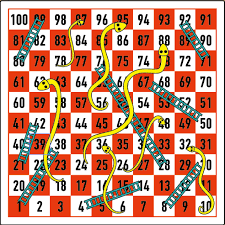

### Part a
Formalize the state space of the Snakes and Ladders game.

The state space is the set of squares on the board that we can describe as  S = {0,...,100} (including the initial state), with terminal state T = {100}

### Part b
Write out the structure of the transition probabilities. Feel free to abbreviate all squares that do not have a snake or ladder.

First we have to be careful about the end of the board, we cannot overshoot when too close to $100$, meaning if we are in 98 for example, then we have $5/6$ chances of landing on 100. So for the last five states:
$$
P(i\rightarrow j) = \frac{1}{6} \, \, \, \forall j \in \{i+1,...,99\} \,,  \,\forall  i \in \{ 95, 96, 97, 98, 99\}
$$
$$
P(i\rightarrow 100)= 1- \frac{100-i+1}{6}
$$

On "generic states" meaning squares without ladder or snake, and before 95, the transition probability is simply
$$
P(i\rightarrow j) = 1/6 \, \, j = i+1,...,i+6
$$
For snakes we have for each $(i,j)$ = (head,tail):
$$
P(i \rightarrow j) = 1
$$
For ladders , for each $(i,j)$ = (bottom,up)
$$
P(i \rightarrow j) = 1
$$

### Part c
Code up a `transition_map: Transition[S]` data structure to represent the transition probabilities of the Snakes and Ladders Markov Process so you can model the game as an instance of `FiniteMarkovProcess`. Use the `traces` method to create sampling traces.

In [2]:
# model board as matrix that will hold probabilities
transition_map = np.zeros((101, 101))
for i in range(1, 101):
    transition_map[i-1, i:i+6] = 1/6
# account for having less than 6 states past space 95
transition_map[95:100, 100] = np.linspace(1/6, 5/6, 5)

# dictionary mapping of snakes and ladders modeled with structure {from space : to space}
snakes = {62: 18, 36: 6, 48: 26, 32: 10, 88: 24, 95: 56, 97: 78}
ladders = {1: 38, 4: 14, 21: 42, 28: 76, 21: 42, 71: 92, 80: 99, 50: 67}

# account for guaranteed probabilities i.e. if you are on a spot with snake or ladder,
# you are guaranteed to go to the specific spot that the snake or ladder ends at (i.e. probability = 1)
for i, j in {**snakes, **ladders}.items():
    transition_map[i-1, :] = 0
    transition_map[i-1, j] = 1
# account for terminal state - probability of staying at 100 is 1 when you are at 100
transition_map[100, :] = 0
transition_map[100, 100] = 1

# snakes_ladders_map data structure is transition_map: Transition[S]
snakes_ladders_map = {}
# set initial probabilities for start state of 0 (left of square 1)
snakes_ladders_map[0] = Categorical({j: 1/6 for j in range(1, 7)})
# set probabilities for other 99 squares - essentially converts transition_map to dictionary
for i in range(1, 100):
    snakes_ladders_map[i] = Categorical({j: prob for j, prob in enumerate(transition_map[i-1]) if prob > 0})
# set terminal state with probability 1
snakes_ladders_map[100] = Categorical({Terminal(100): 1.0})

# create game as instance of FiniteMarkovProcess
snakes_and_ladders_mdp = FiniteMarkovProcess(snakes_ladders_map)
# generate start state distribution for use with traces function (requires start state distribution)
start_state_distribution = Categorical({NonTerminal(0): 1.0})
# generate traces
traces = snakes_and_ladders_mdp.traces(start_state_distribution)

### Part d
Plot the sample traces and a graph of the distribution of time steps to finish the game.

In [3]:
traces_arrays = []
for _ in range(50000):
    states = [state.state for state in next(traces)]
    # gets rid of terminal state, the value in the array: Terminal(state=100)
    del states[-1]
    traces_arrays.append(states)

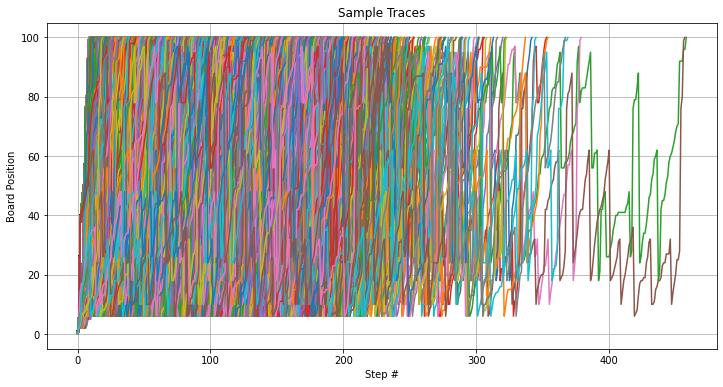

In [4]:
plt.figure(figsize=(12, 6))
for i, trace in enumerate(traces_arrays):
    plt.plot(trace)
plt.xlabel('Step #')
plt.ylabel('Board Position')
plt.title('Sample Traces')
plt.grid()
plt.show()

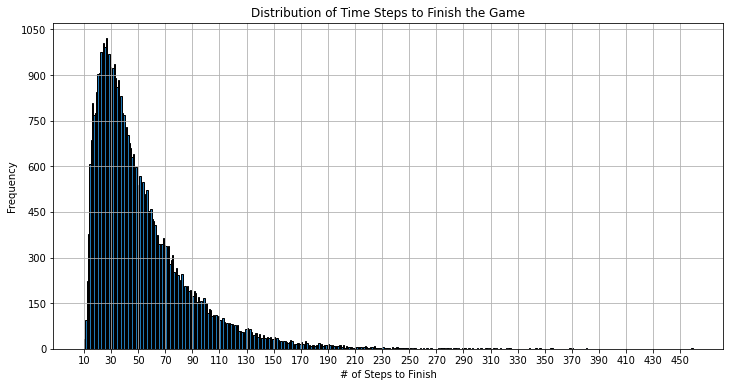

In [5]:
total_steps = [len(trace) for trace in traces_arrays]
plt.figure(figsize=(12, 6))
plt.hist(total_steps, bins=range(min(total_steps), max(total_steps) + 1), edgecolor='black')
plt.xlabel('# of Steps to Finish')
plt.ylabel('Frequency')
plt.title('Distribution of Time Steps to Finish the Game')
plt.xticks(range(min(total_steps), max(total_steps) + 1, 20))
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.show()

### Part e
For the Snakes and Ladders game, calculate the expected number of rolls to finish the game. Hint: in order to calculate this, extend the Snakes and Ladders `FiniteMarkovProcess` to an appropriate `FiniteMarkovRewardProcess` instance. What should be the Rewards model in this MRP so you can use one of the methods in the `FiniteMarkovRewardProcess` class to determine the expected number of dice rolls to finish the game?

In [6]:
# usage of histogram to sanity check below result
print(f"Expected number of dice rolls to finish: {sum(total_steps) / len(total_steps)}")

Expected number of dice rolls to finish: 51.813


In [7]:
# set up reward_map with form key = state, value = finite distribution tuple mapping
reward_map = {}
for state, transitions in snakes_ladders_map.items():
    reward_transitions = {}
    for s, p in transitions:
        # we are penalizing each dice roll (since we want to finish the game as fast as possible)
        # thus, each roll gets a negative reward of -1 to penalize future dice rolls
        # on the terminal state, there is no reward since we are done
        reward = -1 if not isinstance(s, Terminal) else 0
        reward_transitions[(s, reward)] = p
    reward_map[state] = Categorical(reward_transitions)

# FiniteMarkovRewardProcess instance
snakes_and_ladders_mrp = FiniteMarkovRewardProcess(reward_map)

# the value function will give the number of rolls from each state
# we set gamma to 1 since we do not need to discount future rewards because we are modelling a finite game
# to get the expected value, we take the first value since our starting position is at index 0
print("Expected number of dice rolls to finish:", abs(snakes_and_ladders_mrp.get_value_function_vec(1.0)[0]))

Expected number of dice rolls to finish: 50.680458237783625


## Question 2
Consider the problem of a frog jumping across a river with $n=9$ lilypads. The frog at every time step will randomly jump to a position in front of it (e.g. at the starting step, the frog will jump with $\frac{1}{10}$ probability to each of the lilypads or $\frac{1}{10}$ to the other side of the river). A diagram of the frog jumping problem is below.

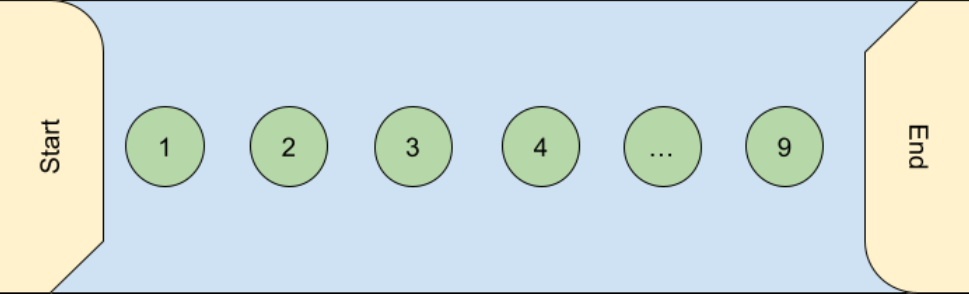

### Part a
Formalize the states of the jumping frog problem as well as the structure of the transition probabilites.

The state space of this problem is $\mathcal{S} = \{Start,1,2,3,...,n,End\}$ $End$ being the unique terminal state. If we use the alias 0 for the $Start$ state and $n+1$ as an alias for End, then the probability transition structure is $ P(i \rightarrow j) = 1/(n+1-i)$

### Part b
Compute the expected number of steps that it would take for the frog to reach the other side.

Let's call $N(n)$ the random variable giving the number of jumps to reach the end given that there are $n$ lilypads seperating the frog from the end. We obsereve that there is a natural recursion in this problem because when jumping to lilypad $i$ there are n-i remaining lilypads in front of the frog so it will realize 1+N(n-i) jumps. For notation convenience, we will use $N(-1)=0$ (when we start directly at the end) and $N(0) = 1$ (there is no lilipad so only one jump is needed for sure). If we name $u_n = E(N(n))$, then the recursion is :
$$
u_n = \sum_{i=1}^{n+1} \frac{1}{n+1} (1+u_{n-i})
$$
Solving for $n=9$ gives around $2.93$ jumps expected

### Part c
Provide a closed form solution for the expected number of steps / jumps to cross the river for arbitrary $n$. A formal proof is not required. 

We can prove that we have the closed form $u_n = \sum_{i=1}^{n+1} \frac{1}{i}$ by recursion.

## Question 3
Consider an MDP with an infinite set of states $\mathcal{S} = \{1,2,3,\ldots \}$. The start state is $s=1$. Each state $s$ allows a continuous set of actions $a \in [0,1]$. The transition probabilities are given by: $$\mathbb{P}[s+1 \mid s, a] = a, \mathbb{P}[s \mid s, a] = 1 - a \text{ for all } s \in \mathcal{S} \text{ for all } a \in [0,1]$$
For all states $s \in \mathcal{S}$ and actions $a \in [0,1]$, transitioning from $s$ to $s+1$ results in a reward of $1-a$ and transitioning from $s$ to $s$ results in a reward of $1+a$. The discount factor $\gamma=0.5$.

### Part a
Using the MDP Bellman Optimality Equation, calculate the Optimal Value Function $V^*(s)$ for all $s \in \mathcal{S}$

We first observe that the problem is completely symmetric across all states $s$ so the value function should be constant $V^*(s) = V^*$. Indeed, We have $V^*(s)  = E(G_t^*|S_t = s)$ but the sequence of rewards/decisions is independant from the start state (each reward only depends on $a$) so we can drop out the conditionning and write : 
$$
V^*(s)  = E( G_t^*|S_t = s) = E( G_t^*) = V^*
$$

In this setting, the Bellman optimality Equation simplifies to:

$$
V^*(s) = V^* =\sup _{a \in [0,1]}\left\{\mathcal{R}(s, a)+\gamma \left( a  V^* + (1-a) V^*\right)\right\}
$$

Where $R(s,a) = a(1-a) + (1-a)(1+a)$. We can solve the max for a given fixed $V^*$:

$$
a^* = argmax _{a \in [0,1]} \mathcal{R}(s, a)+\gamma \left( a  V^* + (1-a) V^*\right)
$$

$$
a^* = argmax _{a \in [0,1]} 1 + \gamma V^* + a -2a^2 
$$

$$
a^* = \frac{1}{4}
$$

So we have:
$$
V^* = 1+\gamma V^* + \frac{1}{8}
$$

With $\gamma = 0.5$ we have the equation : 
$$
V^* = \frac{9}{4}
$$

### Part b
Calculate an Optimal Deterministic Policy $\pi^*(s)$ for all $s \in \mathcal{S}$

The optimal deterministic policy is, as showed in Part a, to systematically choose $a = 1/4$

## Question 4
Consider again the problem of a frog jumping across a river with $n-1$ lilypads, labeled $1, \dots, n-1$, with the two riverbanks labeled positions $0$ and $n$. At each time step, the frog who is at lilypad $i$ has two options:
- (Strategy A) The frog moves to lilypad $i-1$  with probability $\frac{i}{n}$ and moves to lilypad $i+1$ otherwise.
- (Strategy B) The frog moves to arbitrary position from $0,\dots,n$ with equal probability.

The frog now starts on a random lilypad. A snake lives on one end of the river (say the snake lives at 0) and will eat the frog if it lands on this side of the river. The frog can escape by landing the other side of the river (i.e. position $n$). What should the frog's strategy be when on each of the lilypads $1, 2, \ldots, n-1$, in order to maximize the probability of escaping the pond (reaching $n$ before reaching $0$)? Although there are more than one ways of solving this problem, we would like to solve it by modeling it as an MDP and identifying the Optimal Policy.

Note: Sorry for all the frog jumping questions. These games are an easy way to understand Markov Processes, without having to build out too much detail of a financial simulation. Questions will be more related to finance over time.

### Part a
Express with clear mathematical notation the state space, the action space, transition function, and rewards function of an MDP so that the frog-escape problem would be solved by arriving at the Optimal Value Function (and hence, the Optimal Policy) of the MDP.

### Part b
Write code to model this MDP as an instance of the `FiniteMarkovDecisionProcess` class. We have learnt that there exists an optimal deterministic policy, and there are $2^{n-1}$ possible deterministic policies for this problem. Write code to create each of these $2^{n-1}$ deterministic policies (as instances of `FinitePolicy` class), create a policy-implied Finite MRP for each of these deterministic policies (using the `apply_finite_policy` method of `FiniteMarkovDecisionProcess` class), and evaluate the Value Function for each of those implied Finite MRPs (using the `get_value_function_vec` method of `FiniteMarkovRewardProcess` class). This should gives you the Optimal Value Function and the Optimal Deterministic Policy.

### Part c
Plot a graph of the Optimal Escape-Probability and of the associated strategies, as a function of the states of this MDP, for $n=3, n=6$ and $n=9$. By looking at the results on this graph, what pattern do you observe for the optimal policy as you vary $n$ from 3 to 9? 

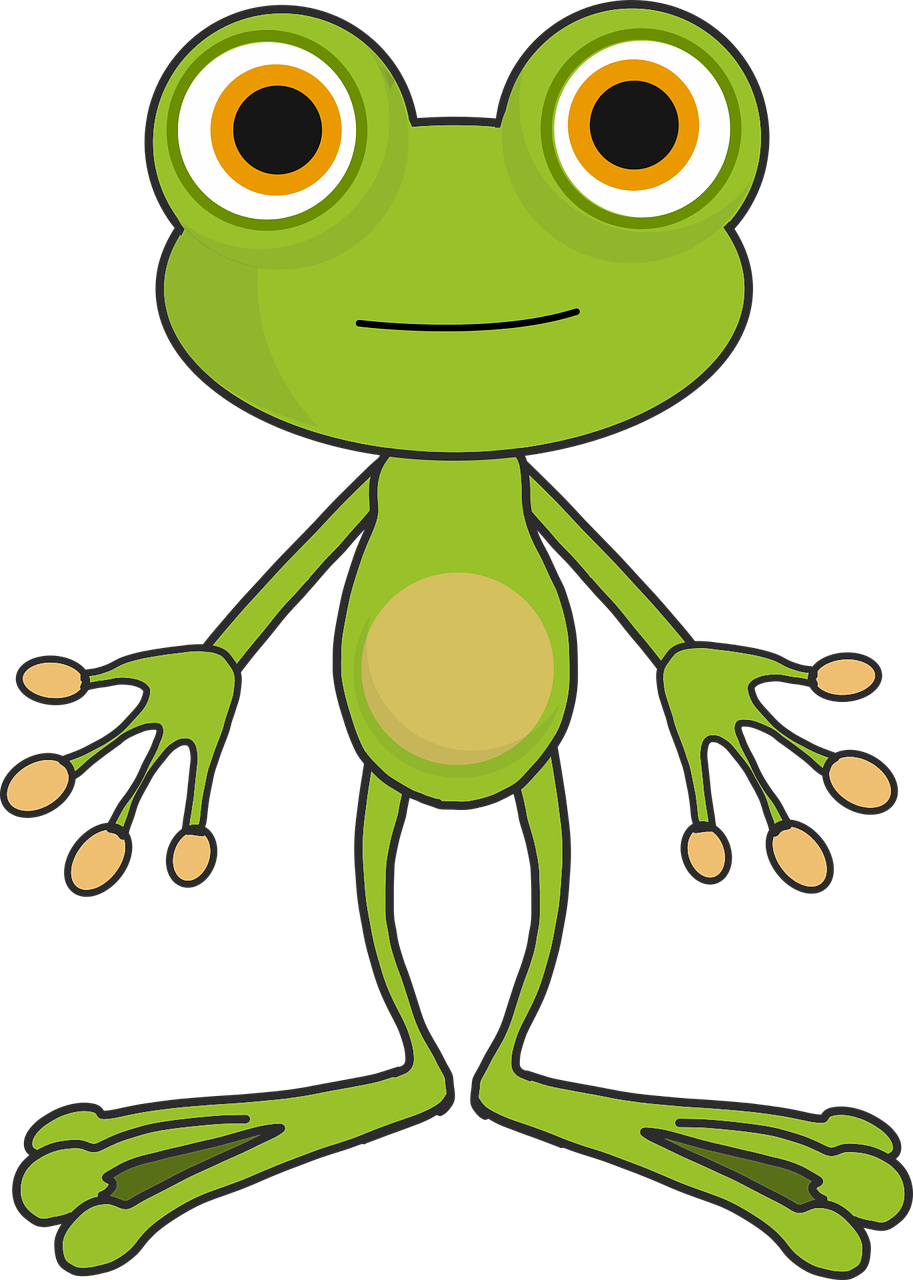